# OPTIONS IMPLIED VOLATILITY SURFACE MODELING

#### Data Fetching

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

In [4]:
ticker = "SPY"
opt = yf.Ticker(ticker)

expirations = opt.options
print(f"Available Expirations: {expirations[:]}")

Available Expirations: ('2025-07-09', '2025-07-10', '2025-07-11', '2025-07-14', '2025-07-15', '2025-07-16', '2025-07-17', '2025-07-18', '2025-07-25', '2025-07-31', '2025-08-01', '2025-08-08', '2025-08-15', '2025-08-22', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-10-31', '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-03-31', '2026-06-18', '2026-06-30', '2026-09-18', '2026-12-18', '2027-01-15', '2027-12-17')


##### Preliminary Overview With One Maturity Date

In [6]:
# Selecting an option 
expiry = expirations[1]

#Fetching option chain
opt_chain = opt.option_chain(expiry)
calls = opt_chain.calls
puts = opt_chain.puts

In [7]:
calls.head()

contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  SPY250710C00450000 2025-07-08 17:25:26+00:00   450.0     170.56  173.23   
1  SPY250710C00500000 2025-07-08 15:04:50+00:00   500.0     120.48  123.24   
2  SPY250710C00510000 2025-07-03 17:04:03+00:00   510.0     115.76  113.24   
3  SPY250710C00520000 2025-06-27 14:04:24+00:00   520.0      95.91  103.24   
4  SPY250710C00565000 2025-07-03 17:06:56+00:00   565.0      60.78   58.25   

      ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  175.34     0.0            0.0     4.0             3           1.871094   
1  125.35     0.0            0.0     2.0             1           1.332035   
2  115.35     0.0            0.0     2.0             1           1.226566   
3  105.35     0.0            0.0     2.0             0           1.123051   
4   60.36     0.0            0.0     1.0             5           0.668949   

   inTheMoney contractSize currency  
0        True      REGULAR      USD  
1        True      REGULAR      USD  
2        True      REGULAR      USD  
3        True      REGULAR      USD  
4        True      REGULAR      USD

In [8]:
# Generating options dataframe
def generate_options(opt_data, opt_type):
    df = opt_data.copy()
    df["option_type"] = opt_type
    df["expiry"] = expiry
    df["mid_price"] = (df["bid"] + df["ask"])/2
    df["bid-ask-spread"] = abs(df["bid"] - df["ask"])

    return df[["strike","lastPrice","bid","ask","mid_price","bid-ask-spread","impliedVolatility", "inTheMoney", "expiry", "option_type","volume"]]

In [9]:
calls_df = generate_options(calls, "calls")
puts_df = generate_options(puts, "puts")

options_df = pd.concat([calls_df, puts_df], axis=0).sort_values(by="strike").reset_index(drop=True)

In [10]:
options_df.head()

strike  lastPrice     bid     ask  mid_price  bid-ask-spread  \
0   450.0     170.56  173.23  175.34    174.285            2.11   
1   450.0       0.01    0.00    0.01      0.005            0.01   
2   465.0       0.02    0.00    0.01      0.005            0.01   
3   470.0       0.01    0.00    0.01      0.005            0.01   
4   475.0       0.01    0.00    0.01      0.005            0.01   

   impliedVolatility  inTheMoney      expiry option_type  volume  
0           1.871094        True  2025-07-10       calls     4.0  
1           1.312503       False  2025-07-10        puts     5.0  
2           1.187504       False  2025-07-10        puts    50.0  
3           1.156254       False  2025-07-10        puts    12.0  
4           1.093755       False  2025-07-10        puts   280.0

In [11]:
options_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   strike             147 non-null    float64
 1   lastPrice          147 non-null    float64
 2   bid                147 non-null    float64
 3   ask                147 non-null    float64
 4   mid_price          147 non-null    float64
 5   bid-ask-spread     147 non-null    float64
 6   impliedVolatility  147 non-null    float64
 7   inTheMoney         147 non-null    bool   
 8   expiry             147 non-null    object 
 9   option_type        147 non-null    object 
 10  volume             142 non-null    float64
dtypes: bool(1), float64(8), object(2)
memory usage: 11.8+ KB


In [12]:
spot_price = opt.history(period="1d")["Close"].iloc[-1]
print(f"Spot Price: {spot_price:.2f}")

Spot Price: 624.06


In [13]:
# Add time to maturity (in years)
today = datetime.today()
options_df['ttm'] = (pd.to_datetime(options_df['expiry']) - today).dt.total_seconds() / (365.25 * 24 * 60 * 60)

In [14]:
options_df["moneyness"] = options_df["strike"]/spot_price
options_df["log_moneyness"] = np.log(options_df["moneyness"])

In [15]:
len(calls)

65

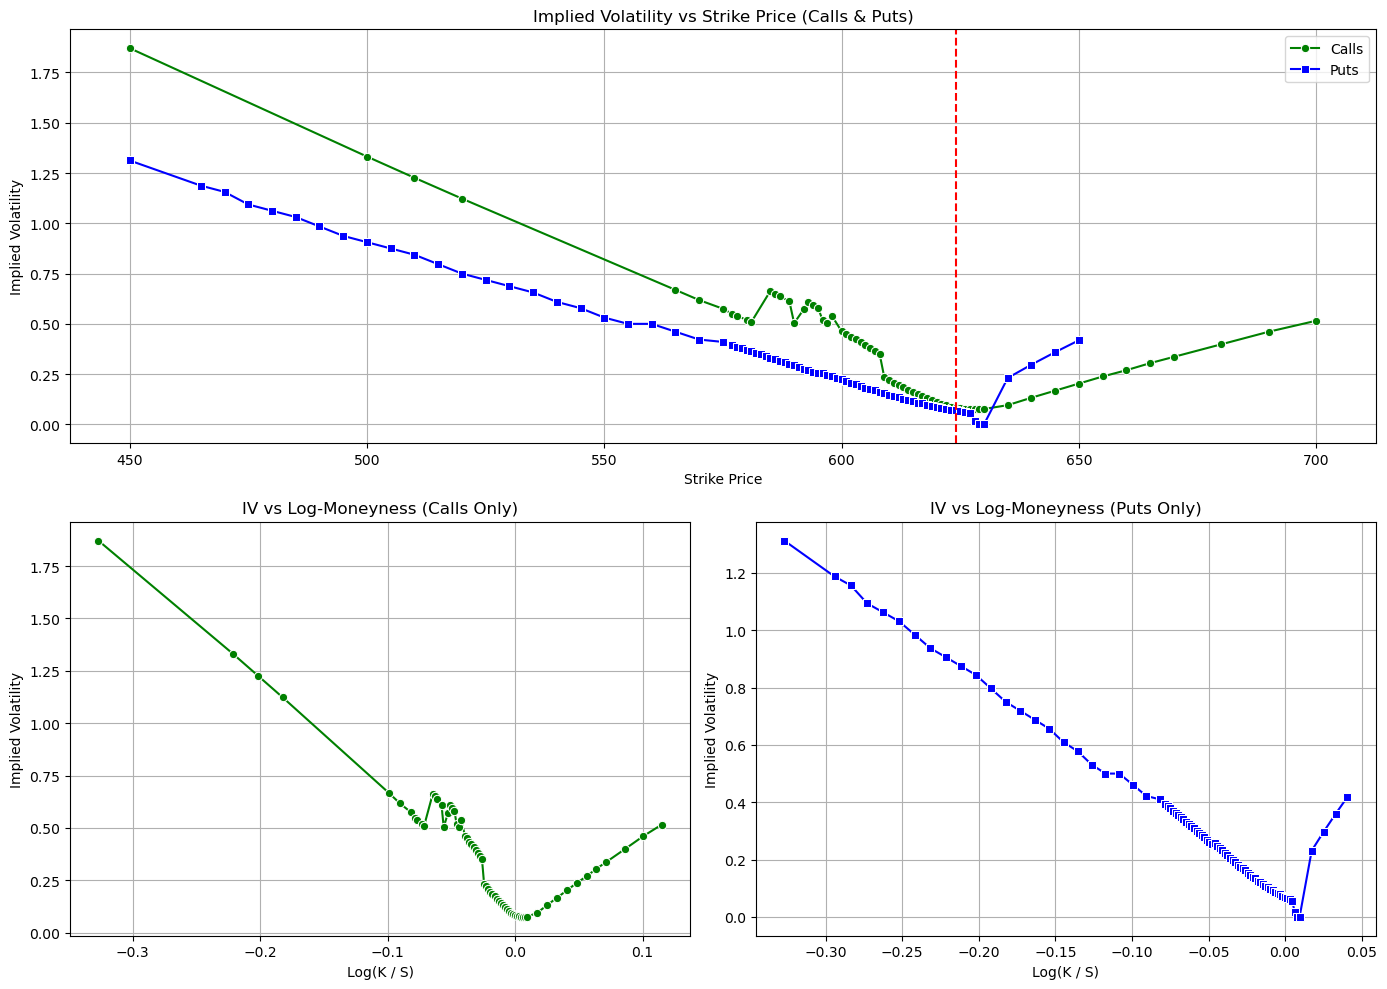

In [16]:
call_options = options_df[options_df['option_type'] == 'calls']
put_options = options_df[options_df['option_type'] == 'puts']

# Set up the figure and grid layout
plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# ========== Top Plot: IV vs Strike (Calls + Puts) ==========
ax0 = plt.subplot(gs[0, :])  # Span both columns
sns.lineplot(data=call_options, x='strike', y='impliedVolatility', label='Calls', marker='o', ax=ax0, color="green")
sns.lineplot(data=put_options, x='strike', y='impliedVolatility', label='Puts', marker='s', ax=ax0, color="blue")
ax0.axvline(spot_price, color="red", linestyle="--")
ax0.set_title('Implied Volatility vs Strike Price (Calls & Puts)')
ax0.set_xlabel('Strike Price')
ax0.set_ylabel('Implied Volatility')
ax0.grid(True)
ax0.legend()

# ========== Bottom Left Plot: IV vs Log-Moneyness (Calls Only) ==========
ax1 = plt.subplot(gs[1, 0])
sns.lineplot(data=call_options, x='log_moneyness', y='impliedVolatility', marker='o', ax=ax1, color="green")
ax1.set_title('IV vs Log-Moneyness (Calls Only)')
ax1.set_xlabel('Log(K / S)')
ax1.set_ylabel('Implied Volatility')
ax1.grid(True)

# ========== Bottom Right Plot: IV vs Log-Moneyness (Puts Only) ==========
ax2 = plt.subplot(gs[1, 1])
sns.lineplot(data=put_options, x='log_moneyness', y='impliedVolatility', marker='s', ax=ax2, color="blue")
ax2.set_title('IV vs Log-Moneyness (Puts Only)')
ax2.set_xlabel('Log(K / S)')
ax2.set_ylabel('Implied Volatility')
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

From this IV vs K and IV vs Log(K/S), we can see that implied volatility is higher for out-of-the-money put and in-the-money-call options

##### Understanding how IV changes with both Strike and Maturity - Multiple Expiry

In [19]:
smile_snapshots = []

for expiry in expirations[:]:  # Limit for now
    chain = opt.option_chain(expiry)
    calls = generate_options(chain.calls, 'calls')
    puts = generate_options(chain.puts, 'puts')
    multi_mat_options_data = pd.concat([calls,puts], axis=0)
    multi_mat_options_data['expiry'] = pd.to_datetime(expiry)
    multi_mat_options_data['ttm'] = (pd.to_datetime(multi_mat_options_data['expiry']) - datetime.today()).dt.total_seconds() / (365.25 * 24 * 60 * 60)
    multi_mat_options_data['moneyness'] = multi_mat_options_data['strike'] / spot_price
    multi_mat_options_data['log_moneyness'] = np.log(multi_mat_options_data['moneyness'])

    smile_snapshots.append(multi_mat_options_data[["strike","lastPrice","bid","ask","bid-ask-spread","mid_price","impliedVolatility", "inTheMoney", "expiry", "option_type","ttm","moneyness","log_moneyness","volume"]])

# Combine all smiles
smile_df = pd.concat(smile_snapshots).reset_index(drop=True)

In [20]:
smile_df.head()

strike  lastPrice     bid     ask  bid-ask-spread  mid_price  \
0   450.0     173.50  173.22  174.92            1.70    174.070   
1   500.0     125.45  123.22  125.01            1.79    124.115   
2   520.0     103.44  103.22  105.02            1.80    104.120   
3   540.0      81.97   83.22   84.92            1.70     84.070   
4   550.0      70.37   73.22   75.02            1.80     74.120   

   impliedVolatility  inTheMoney     expiry option_type       ttm  moneyness  \
0           1.937500        True 2025-07-09       calls -0.002731   0.721085   
1           1.585940        True 2025-07-09       calls -0.002731   0.801205   
2           1.343753        True 2025-07-09       calls -0.002731   0.833253   
3           0.921876        True 2025-07-09       calls -0.002731   0.865301   
4           0.964844        True 2025-07-09       calls -0.002731   0.881326   

   log_moneyness  volume  
0      -0.326999     3.0  
1      -0.221638    14.0  
2      -0.182418     2.0  
3      -0.144677     1.0  
4      -0.126328   244.0

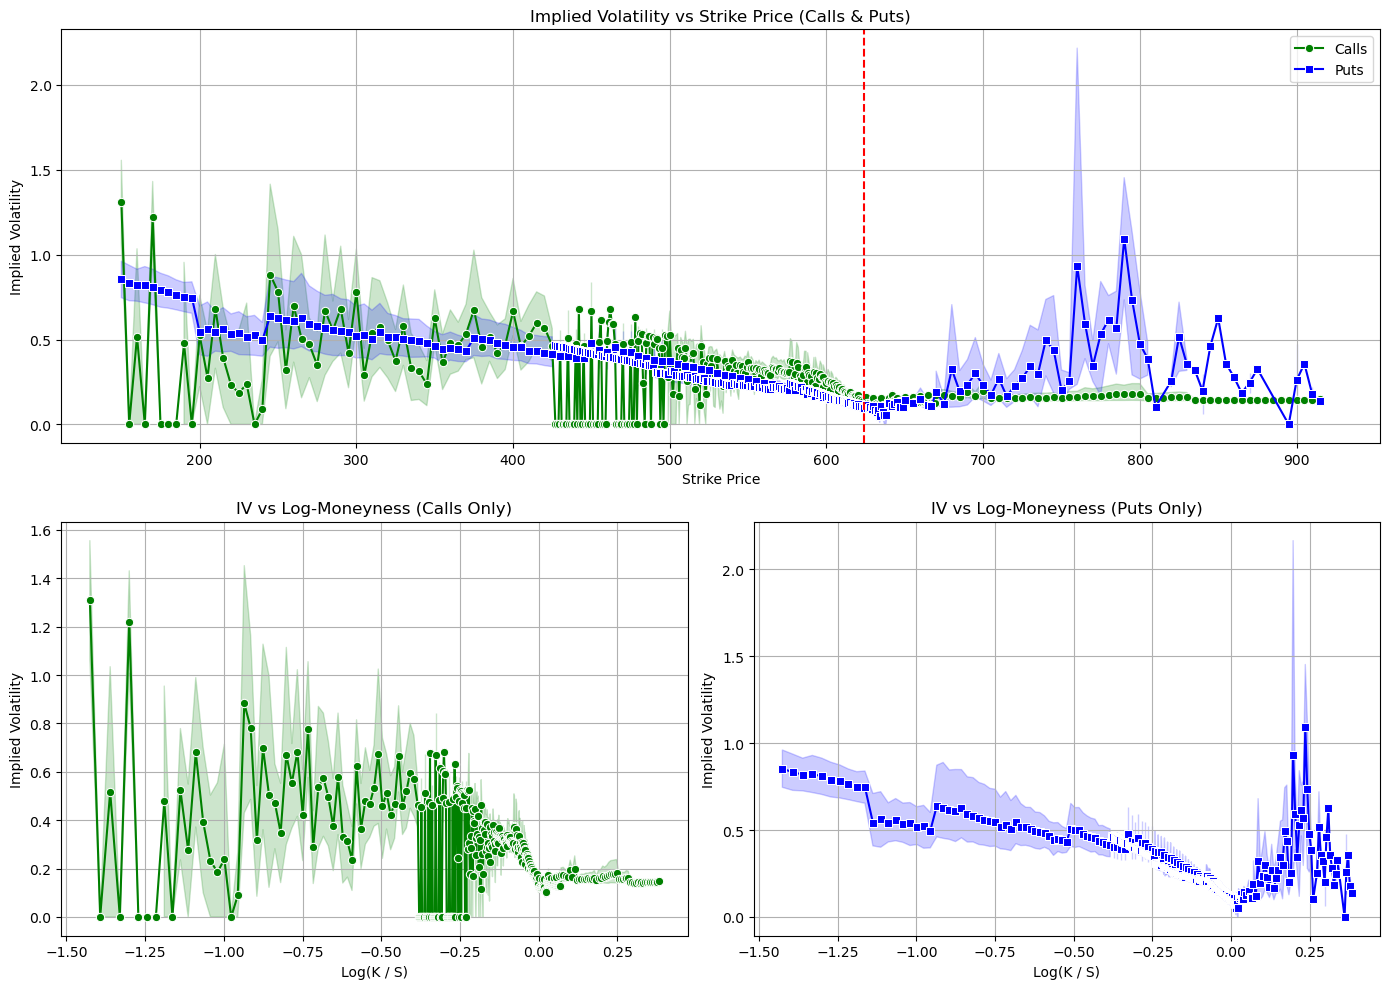

In [21]:
call_options = smile_df[smile_df['option_type'] == 'calls']
put_options = smile_df[smile_df['option_type'] == 'puts']

# Set up the figure and grid layout
plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# ========== Top Plot: IV vs Strike (Calls + Puts) ==========
ax0 = plt.subplot(gs[0, :])  # Span both columns
sns.lineplot(data=call_options, x='strike', y='impliedVolatility', label='Calls', marker='o', ax=ax0, color="green")
sns.lineplot(data=put_options, x='strike', y='impliedVolatility', label='Puts', marker='s', ax=ax0, color="blue")
ax0.axvline(spot_price, color="red", linestyle="--")
ax0.set_title('Implied Volatility vs Strike Price (Calls & Puts)')
ax0.set_xlabel('Strike Price')
ax0.set_ylabel('Implied Volatility')
ax0.grid(True)
ax0.legend()

# ========== Bottom Left Plot: IV vs Log-Moneyness (Calls Only) ==========
ax1 = plt.subplot(gs[1, 0])
sns.lineplot(data=call_options, x='log_moneyness', y='impliedVolatility', marker='o', ax=ax1, color="green")
ax1.set_title('IV vs Log-Moneyness (Calls Only)')
ax1.set_xlabel('Log(K / S)')
ax1.set_ylabel('Implied Volatility')
ax1.grid(True)

# ========== Bottom Right Plot: IV vs Log-Moneyness (Puts Only) ==========
ax2 = plt.subplot(gs[1, 1])
sns.lineplot(data=put_options, x='log_moneyness', y='impliedVolatility', marker='s', ax=ax2, color="blue")
ax2.set_title('IV vs Log-Moneyness (Puts Only)')
ax2.set_xlabel('Log(K / S)')
ax2.set_ylabel('Implied Volatility')
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

##### Investigating high IV contracts

We can see from the plot of maturities between 2025-06-30 to 2025-07-07 that there are ITM put options and ITM call options trades that are highly volatile. This could be as a result of high demand and the instance of high IV for OTM options could be attributed to these contracts being illiquid, that is, stale last price, low volume or wide bid-ask spread

In [24]:
len(smile_df[smile_df["impliedVolatility"]>2])

10

In [25]:
print(f"Expiry for high IV contracts:\n{smile_df.iloc[smile_df[smile_df["impliedVolatility"]>2].index].expiry.value_counts()}\n")
print(f"Option Distribution for high IV contracts:\n{smile_df.iloc[smile_df[smile_df["impliedVolatility"]>2].index].option_type.value_counts()}\n")

Expiry for high IV contracts:
expiry
2025-07-18    7
2025-07-11    3
Name: count, dtype: int64

Option Distribution for high IV contracts:
option_type
calls    8
puts     2
Name: count, dtype: int64



Most of the contracts with this high IV come from 2025-06-30 and are majorly call options with puts being about 34% of the population (though with higher volatility than calls).
This rise in volatility could be largely attributed to the fact that the current date is the expiry, that is today's date (when this analysis is being performed is the expiry date)

In [27]:
smile_df[smile_df["impliedVolatility"]>2]

strike  lastPrice     bid     ask  bid-ask-spread  mid_price  \
298    375.0     247.61  248.38  250.49            2.11    249.435   
299    380.0     222.31  243.38  245.13            1.75    244.255   
300    400.0     223.83  223.39  225.29            1.90    224.340   
933    245.0     375.54  379.40  379.73            0.33    379.565   
934    250.0     350.95  373.54  375.24            1.70    374.390   
935    260.0     366.49  364.42  364.75            0.33    364.585   
936    265.0     334.57  358.56  360.46            1.90    359.510   
937    280.0     314.51  343.58  345.50            1.92    344.540   
1280   680.0     120.15  144.03  147.50            3.47    145.765   
1286   760.0     191.24  230.71  234.08            3.37    232.395   

      impliedVolatility  inTheMoney     expiry option_type       ttm  \
298            2.429691        True 2025-07-11       calls  0.002745   
299            2.191411        True 2025-07-11       calls  0.002745   
300            2.072270        True 2025-07-11       calls  0.002745   
933            2.416020        True 2025-07-18       calls  0.021910   
934            2.248051        True 2025-07-18       calls  0.021910   
935            2.284184        True 2025-07-18       calls  0.021910   
936            2.194340        True 2025-07-18       calls  0.021910   
937            2.080083        True 2025-07-18       calls  0.021910   
1280           2.710269        True 2025-07-18        puts  0.021910   
1286           3.449953        True 2025-07-18        puts  0.021910   

      moneyness  log_moneyness  volume  
298    0.600904      -0.509320     1.0  
299    0.608916      -0.496075    15.0  
300    0.640964      -0.444782     8.0  
933    0.392590      -0.934988    12.0  
934    0.400603      -0.914786    12.0  
935    0.416627      -0.875565   212.0  
936    0.424639      -0.856517     NaN  
937    0.448675      -0.801457     1.0  
1280   1.089639       0.085846    10.0  
1286   1.217832       0.197072     1.0

In [28]:
print(f"Average Bid-Ask Spread of the entire population:\n{smile_df["bid-ask-spread"].mean()}\n")
print(f"Average Bid-Ask Spread of the high volatility population:\n{smile_df[smile_df["impliedVolatility"]>2]["bid-ask-spread"].mean()}")

Average Bid-Ask Spread of the entire population:
0.9998036723163841

Average Bid-Ask Spread of the high volatility population:
1.878000000000003


The wide bid-ask spread for the high volatility contracts confirms earlier stated facts, indicating market makers widening the spread during this period to manage increased risk associated with price fluctuations. 

In [30]:
filtered_df = smile_df.drop(smile_df[smile_df["impliedVolatility"]>2].index)

In [31]:
filtered_df["bid-ask-spread"].mean()

0.9985615275813295

In [32]:
len(smile_df), len(filtered_df)

(7080, 7070)

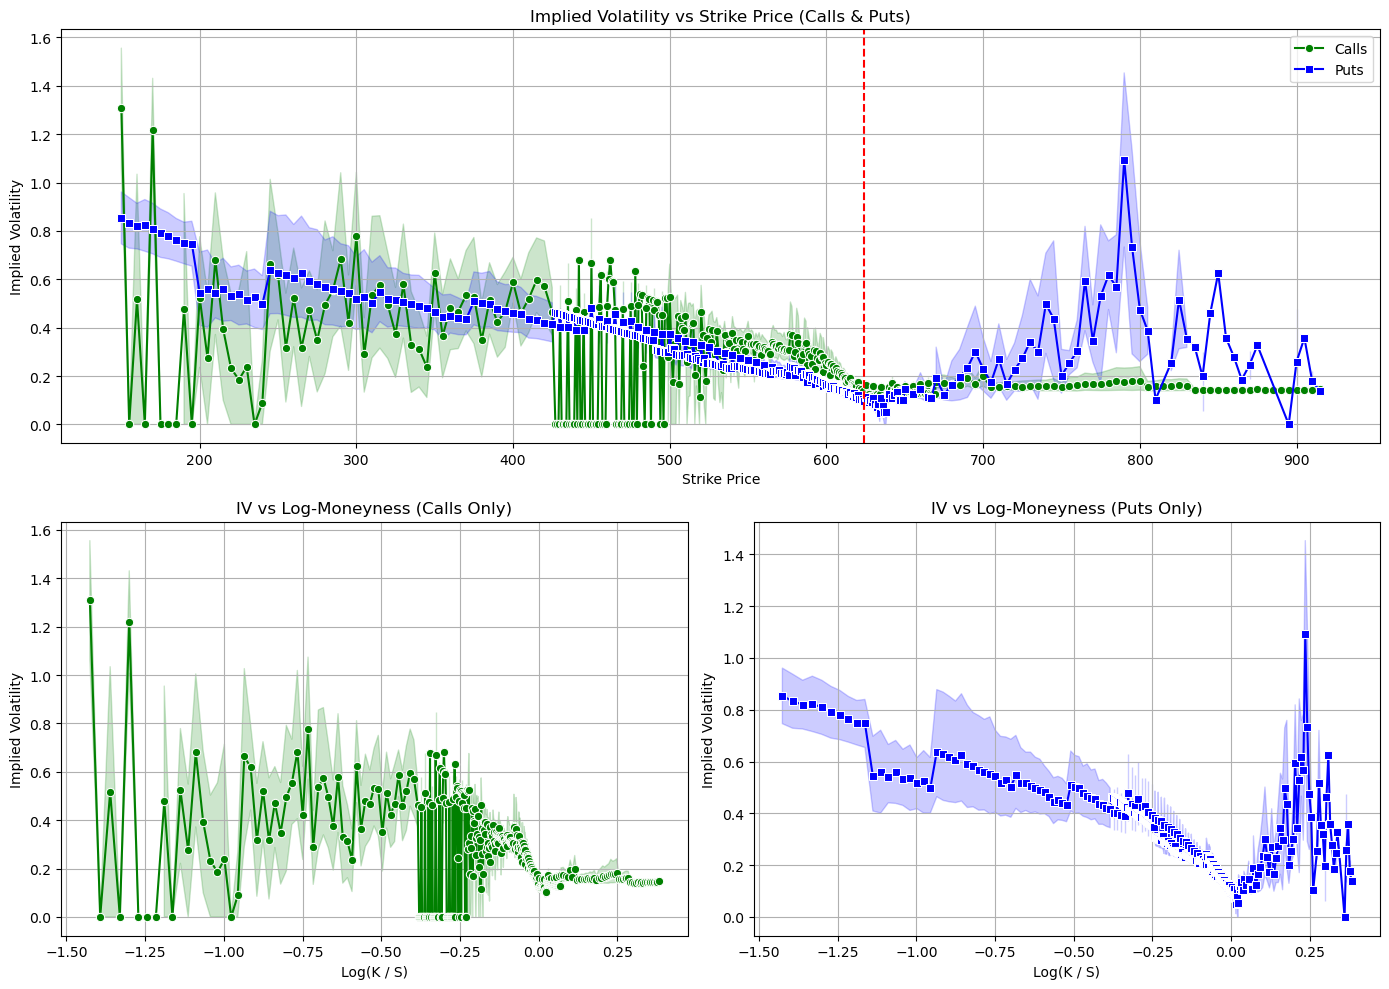

In [33]:
call_options = filtered_df[filtered_df['option_type'] == 'calls']
put_options = filtered_df[filtered_df['option_type'] == 'puts']

# Set up the figure and grid layout
plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# ========== Top Plot: IV vs Strike (Calls + Puts) ==========
ax0 = plt.subplot(gs[0, :])  # Span both columns
sns.lineplot(data=call_options, x='strike', y='impliedVolatility', label='Calls', marker='o', ax=ax0, color="green")
sns.lineplot(data=put_options, x='strike', y='impliedVolatility', label='Puts', marker='s', ax=ax0, color="blue")
ax0.axvline(spot_price, color="red", linestyle="--")
ax0.set_title('Implied Volatility vs Strike Price (Calls & Puts)')
ax0.set_xlabel('Strike Price')
ax0.set_ylabel('Implied Volatility')
ax0.grid(True)
ax0.legend()

# ========== Bottom Left Plot: IV vs Log-Moneyness (Calls Only) ==========
ax1 = plt.subplot(gs[1, 0])
sns.lineplot(data=call_options, x='log_moneyness', y='impliedVolatility', marker='o', ax=ax1, color="green")
ax1.set_title('IV vs Log-Moneyness (Calls Only)')
ax1.set_xlabel('Log(K / S)')
ax1.set_ylabel('Implied Volatility')
ax1.grid(True)

# ========== Bottom Right Plot: IV vs Log-Moneyness (Puts Only) ==========
ax2 = plt.subplot(gs[1, 1])
sns.lineplot(data=put_options, x='log_moneyness', y='impliedVolatility', marker='s', ax=ax2, color="blue")
ax2.set_title('IV vs Log-Moneyness (Puts Only)')
ax2.set_xlabel('Log(K / S)')
ax2.set_ylabel('Implied Volatility')
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

##### Analyzing smile behaviour across maturities

In [35]:
filtered_df.describe()

strike    lastPrice          bid          ask  bid-ask-spread  \
count  7070.000000  7070.000000  7070.000000  7070.000000     7070.000000   
mean    548.660750    52.404795    52.949471    53.948033        0.998562   
min     150.000000     0.010000     0.000000     0.000000        0.000000   
25%     480.000000     1.282500     1.190000     1.220000        0.020000   
50%     571.000000    12.480000    11.475000    11.700000        0.070000   
75%     621.000000    68.445000    69.250000    71.657500        1.880000   
max     915.000000   475.530000   474.580000   477.540000      252.310000   
std     128.055188    81.988266    84.105331    85.308781        3.340928   

         mid_price  impliedVolatility                         expiry  \
count  7070.000000        7070.000000                           7070   
mean     53.448752           0.292082  2025-12-24 03:46:53.804808960   
min       0.000000           0.000010            2025-07-09 00:00:00   
25%       1.202500           0.149865            2025-07-31 00:00:00   
50%      11.612500           0.230156            2025-09-30 00:00:00   
75%      70.508750           0.363288            2026-03-20 00:00:00   
max     475.815000           1.987305            2027-12-17 00:00:00   
std      84.692721           0.228257                            NaN   

               ttm    moneyness  log_moneyness         volume  
count  7070.000000  7070.000000    7070.000000    6867.000000  
mean      0.457660     0.879179      -0.161491    1151.342071  
min      -0.002731     0.240362      -1.425611       1.000000  
25%       0.057502     0.769157      -0.262460       2.000000  
50%       0.224511     0.914976      -0.088857       7.000000  
75%       0.692683     0.995097      -0.004915      67.000000  
max       2.436694     1.466205       0.382678  555097.000000  
std       0.575186     0.205197       0.271069   15844.087831

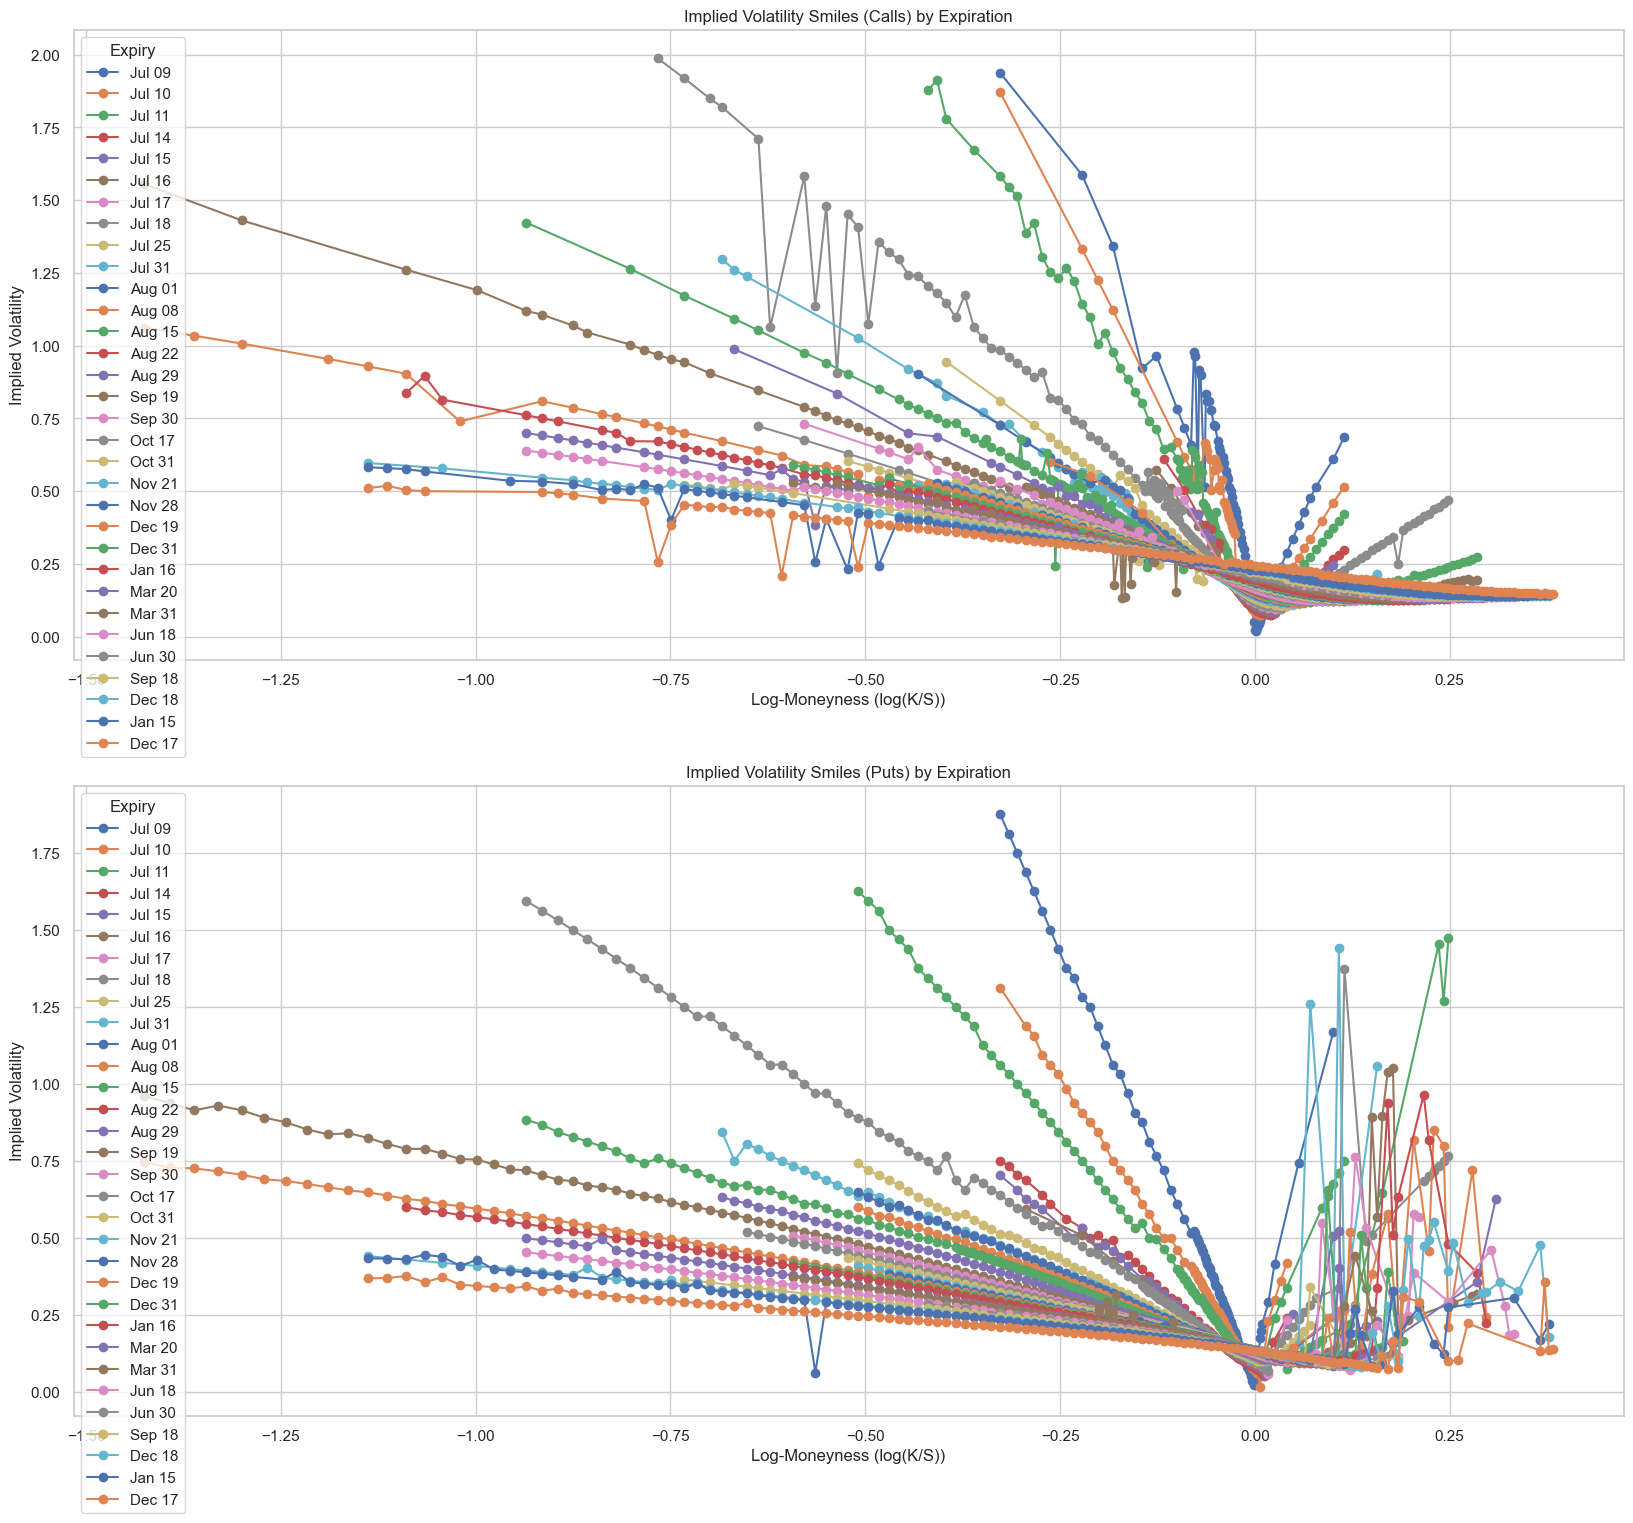

In [36]:
smooth_calls = filtered_df[(filtered_df["impliedVolatility"]>0.01) & (filtered_df["impliedVolatility"]<=2) & (filtered_df["option_type"]=="calls")]
call_unique_exps = sorted(smooth_calls["expiry"].unique())

sns.set(style="whitegrid")
fig, ax = plt.subplots(2,1,figsize=(20,18))

for expiry in call_unique_exps:
    subset = smooth_calls[smooth_calls["expiry"]==expiry]
    subset_sorted = subset.sort_values(by="log_moneyness")
    label = expiry.strftime("%b %d")
    ax[0].plot(subset_sorted["log_moneyness"], subset_sorted["impliedVolatility"], marker="o", label=label)

ax[0].set_title("Implied Volatility Smiles (Calls) by Expiration")    
ax[0].set_xlabel("Log-Moneyness (log(K/S))")
ax[0].set_ylabel("Implied Volatility")
ax[0].legend(title="Expiry")
plt.grid(True)


smooth_puts = filtered_df[(filtered_df["impliedVolatility"]>0.01) & (filtered_df["impliedVolatility"]<=2) & (filtered_df["option_type"]=="puts")]
put_unique_exps = sorted(smooth_puts["expiry"].unique())

for expiry in put_unique_exps:
    subset = smooth_puts[smooth_puts["expiry"]==expiry]
    subset_sorted = subset.sort_values(by="log_moneyness")
    label = expiry.strftime("%b %d")
    ax[1].plot(subset_sorted["log_moneyness"], subset_sorted["impliedVolatility"], marker="o", label=label)
    
ax[1].set_title("Implied Volatility Smiles (Puts) by Expiration")    
ax[1].set_xlabel("Log-Moneyness (log(K/S))")
ax[1].set_ylabel("Implied Volatility")
ax[1].legend(title="Expiry")
plt.grid(True)
plt.show()

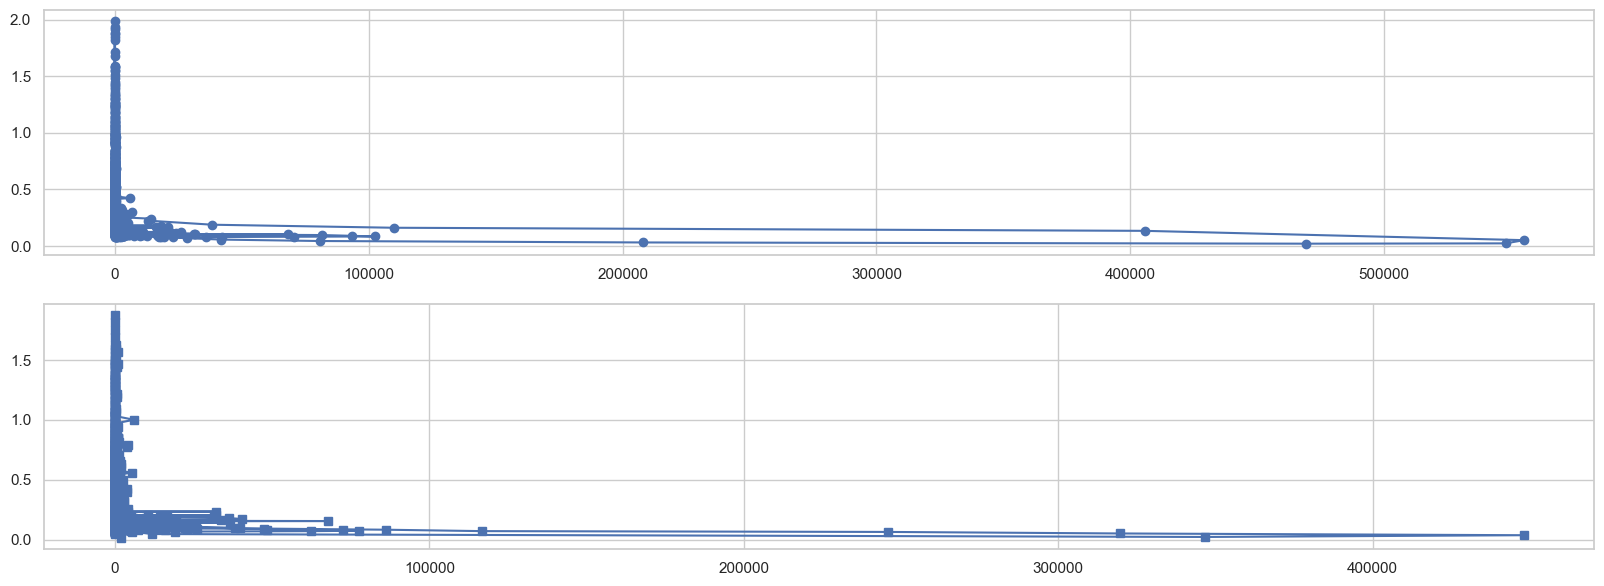

In [37]:
fig, ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(smooth_calls["volume"], smooth_calls["impliedVolatility"], marker="o")
ax[1].plot(smooth_puts["volume"], smooth_puts["impliedVolatility"], marker="s")

From the plot of IV vs Log(K/S) we can see a higher convexity for contracts with shorter maturity than contracts with longer maturities (this shows that the IV curves match empirical finance theories), as well as deep ITM and OTM experiencing higher volatility. 

From the analysis and visualisation so far, conclusively, the increasing IV can be attributed to low liquidity contracts with wide bid-ask spread and discontinuities from close-to-expiry contracts

In [39]:
len(smile_df[smile_df["mid_price"]>0.05])/len(smile_df)*100

90.57909604519774

In [40]:
len(smile_df[(smile_df["mid_price"]>=-0.1) & (smile_df["mid_price"]<=0.1)])/len(smile_df)*100

12.005649717514125

In [41]:
len(smile_df[smile_df["volume"]>50])/len(smile_df)*100

26.864406779661014

In [42]:
smile_df["ttm"].value_counts()

ttm
 0.098570    456
 0.224511    378
 0.057502    371
 0.021910    360
 0.476393    308
 0.136900    304
 0.309384    290
 0.722800    288
 2.436694    265
 0.443539    263
 0.194394    260
 1.440117    259
 1.516776    252
 0.520199    240
 0.002745    233
 0.939090    229
 0.386044    221
 0.692683    220
 0.041075    213
 0.060240    204
 0.079405    178
 1.190972    177
-0.002731    151
 0.000007    147
 0.010959    142
 0.271054    133
 0.013696    129
 0.366879    125
 0.971944    109
 0.016434     96
 0.117735     44
 0.019172     35
Name: count, dtype: int64

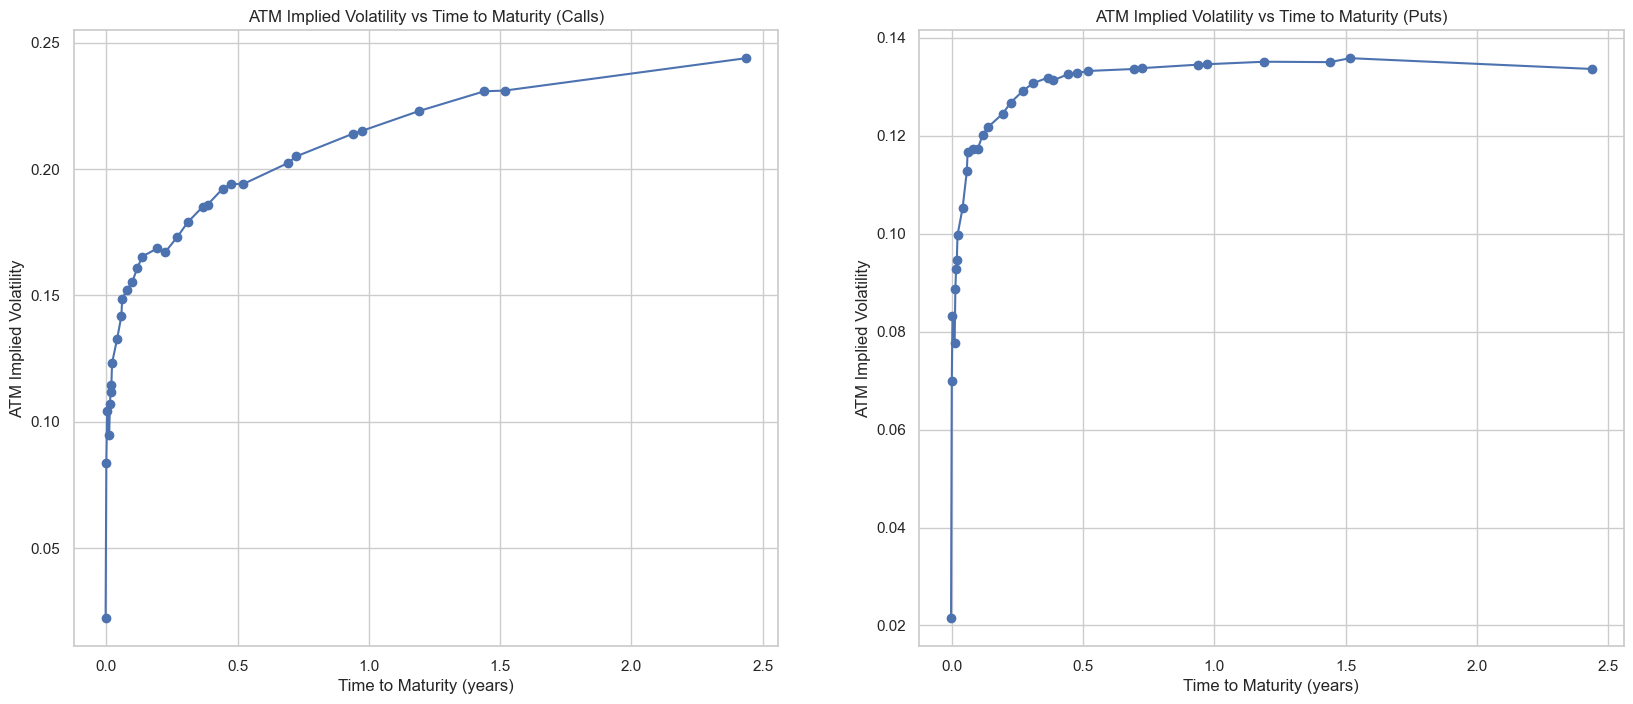

In [43]:
# Approximate ATM as nearest log-moneyness ≈ 0
atm_ivs_calls = []
atm_ivs_puts = []

fig, ax = plt.subplots(1,2,figsize=(20,8))

for expiry in call_unique_exps:
    sub = smooth_calls[smooth_calls['expiry'] == expiry]
    atm_row = sub.iloc[(sub['log_moneyness'] - 0).abs().argsort()[:1]]  # closest to ATM "0" has no mathematical significance to the calculation but is there for clarity to indicate ATM log difference
    atm_iv = atm_row['impliedVolatility'].values[0]
    ttm = atm_row['ttm'].values[0]
    atm_ivs_calls.append((ttm, atm_iv))

atm_df_calls = pd.DataFrame(atm_ivs_calls, columns=['ttm', 'iv'])

# Plot
ax[0].plot(atm_df_calls['ttm'], atm_df_calls['iv'], marker='o')
ax[0].set_title('ATM Implied Volatility vs Time to Maturity (Calls)')
ax[0].set_xlabel('Time to Maturity (years)')
ax[0].set_ylabel('ATM Implied Volatility')

for expiry in put_unique_exps:
    sub = smooth_puts[smooth_puts['expiry'] == expiry]
    atm_row = sub.iloc[(sub['log_moneyness'] - 0).abs().argsort()[:1]]  # closest to ATM
    atm_iv = atm_row['impliedVolatility'].values[0]
    ttm = atm_row['ttm'].values[0]
    atm_ivs_puts.append((ttm, atm_iv))

atm_df_puts = pd.DataFrame(atm_ivs_puts, columns=['ttm', 'iv'])

# Plot
ax[1].plot(atm_df_puts['ttm'], atm_df_puts['iv'], marker='o')
ax[1].set_title('ATM Implied Volatility vs Time to Maturity (Puts)')
ax[1].set_xlabel('Time to Maturity (years)')
ax[1].set_ylabel('ATM Implied Volatility')
plt.grid(True)
plt.show()

### Modeling SVI

#### SVI Total Variance Formula

The SVI model parameterizes the total implied variance \( w(k) = \sigma_{BS}^2(k) \cdot T\) as:
$$
w(k) = a + b\left( \rho (k-m) + \sqrt{(k-m)^2 + \sigma^2} \right)
$$

where:
$$
- \( k = \log(K/F) \): Log-moneyness (strike \( K \) vs. forward price \( F \))
$$

 
- Parameters:
  - \( a \): Level of overall variance
  - \( b \): Slope of wings
  - \( \rho \): Skew (asymmetry) control
  - \( m \): Horizontal shift of the smile
  - \( \sigma \): Smoothness of the ATM curvature

### Arbitrage-Free Constraints
For no static arbitrage:
1. **Positivity**:  
   \( b > 0 \), \( \sigma > 0 \)
2. **Vertical Asymptotes**:  
   \( |\rho| < 1 \)
3. **Monotonicity & Convexity**:  
   \( b (1 + |\rho|) \leq \frac{4}{T} \)

In [82]:
model_data = pd.concat([smooth_calls, smooth_puts], axis=0)

# Pick a clean expiry
selected_expiry = pd.to_datetime("2025-07-10")
ttm = model_data[model_data["expiry"]==selected_expiry]["ttm"].iloc[0]

In [84]:
ttm

7.184220441351687e-06

#### **SVI Modeling for Single Maturity**

In [87]:
def svi_total_variance(k, a, b, rho, m, sigma):
    return a + b * (rho * (k-m) + np.sqrt((k-m)**2) + sigma**2)

In [89]:
model_data["total_variance"] = (model_data["impliedVolatility"]**2) * model_data["ttm"]

call_model_data, put_model_data = (model_data[(model_data["expiry"]==selected_expiry) & (model_data["option_type"]=="calls")],
                                   model_data[(model_data["expiry"]==selected_expiry) & (model_data["option_type"]=="puts")])

len(call_model_data), len(put_model_data)

(65, 80)

In [91]:
from scipy.optimize import curve_fit

# Optimizing calls
k_data = call_model_data["log_moneyness"].values
w_data = call_model_data["total_variance"].values

# initial guess
x0 = [0.01, 0.1, -0.5, 0.0, 0.1]
# Bounds: to constrain parameters to realistic financial values
bounds = (
    [-np.inf, 0.0001, -0.999, -1.0, 0.0001],
    [np.inf, 2.0, 0.999, 1.0, 2.0]
)

params, _ = curve_fit(svi_total_variance, k_data, w_data, p0=x0, bounds=bounds)
a, b, rho, m, sigma = params
print(f"SVI Parameters: a={a:.4f}, b={b:.4f}, rho={rho:.4f}, m={m:.4f}, sigma={sigma:.4f}")

SVI Parameters: a=-0.0000, b=0.0017, rho=0.9723, m=0.1128, sigma=0.1000


/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_4193/4229866000.py:5: RuntimeWarning: invalid value encountered in sqrt
  iv_fit = np.sqrt(w_fit/ttm)


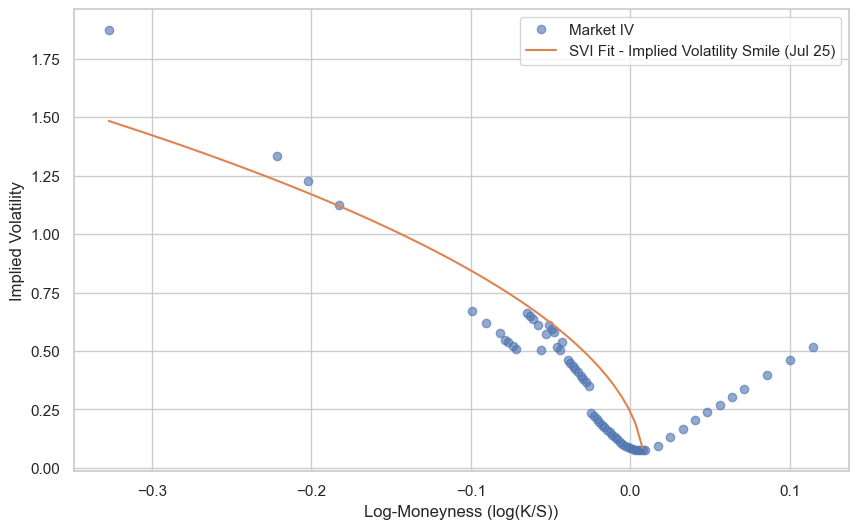

In [93]:
# Generating fitted curve

k_fit = np.linspace(min(k_data), max(k_data), 100)
w_fit = svi_total_variance(k_fit, *params)
iv_fit = np.sqrt(w_fit/ttm)

iv_market = np.sqrt(w_data/ttm)

plt.figure(figsize=(10,6))
plt.plot(k_data, iv_market, "o", label="Market IV", alpha=0.6)
plt.plot(k_fit, iv_fit, "-", label=f"SVI Fit - Implied Volatility Smile ({selected_expiry.strftime("%b %y")})")
plt.xlabel("Log-Moneyness (log(K/S))")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()

In [94]:
smile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   strike             7080 non-null   float64       
 1   lastPrice          7080 non-null   float64       
 2   bid                7080 non-null   float64       
 3   ask                7080 non-null   float64       
 4   bid-ask-spread     7080 non-null   float64       
 5   mid_price          7080 non-null   float64       
 6   impliedVolatility  7080 non-null   float64       
 7   inTheMoney         7080 non-null   bool          
 8   expiry             7080 non-null   datetime64[ns]
 9   option_type        7080 non-null   object        
 10  ttm                7080 non-null   float64       
 11  moneyness          7080 non-null   float64       
 12  log_moneyness      7080 non-null   float64       
 13  volume             6876 non-null   float64       
dtypes: bool(

#### **SVI Modeling for Multiple Maturities**

In [98]:
def fit_svi(k_data, w_data, ttm):
    
    # initial guess
    x0 = [0.01, 0.1, -0.5, 0.0, 0.1]
    # Bounds: to constrain parameters to realistic financial values
    bounds = (
        [0, 0.0001, -0.999, -1.0, 0.0001],
        [np.inf, 2.0, 0.999, 1.0, 2.0]
    )

    try:
        params, _ = curve_fit(svi_total_variance, k_data, w_data, p0=x0, bounds=bounds)
        w_fit = svi_total_variance(k_data, *params)
        rmse = np.sqrt(np.mean(w_fit-w_data)**2)
        return params, rmse
    except Exception as e:
        print(f"SVI fit failed: {e}")
        return None, None

In [100]:
# Storing parameters and diagnostics
svi_results = []

# Defining expiries to process
expiries_to_fit = sorted(model_data["expiry"].unique())

for expiry in expiries_to_fit:
    subset = model_data[
    (model_data["expiry"]==expiry)
    ].copy()

    if len(subset)<10:
        continue

    ttm = subset["ttm"].iloc[0]
    k_data = subset["log_moneyness"].values
    w_data = (subset["impliedVolatility"].values**2) * ttm

    params, rmse = fit_svi(k_data, w_data, ttm)

    if params is not None:
        svi_results.append({
            "expiry":expiry,
            "ttm":ttm,
            "a":params[0],
            "b":params[1],
            "rho":params[2],
            "m":params[3],
            "sigma":params[4],
            "rmse":rmse
        })

In [102]:
svi_df = pd.DataFrame(svi_results)
svi_df = svi_df.sort_values(by="ttm", ascending=False).reset_index(drop=True)
svi_df.head()

expiry       ttm         a         b       rho         m     sigma  \
0 2027-12-17  2.436694  0.064638  0.162021 -0.875662  0.099456  0.084577   
1 2027-01-15  1.516776  0.041079  0.141030 -0.999000  0.009585  0.089306   
2 2026-12-18  1.440117  0.036964  0.219943 -0.284479  0.028894  0.084563   
3 2026-09-18  1.190972  0.024097  0.130300 -0.999000  0.041847  0.091173   
4 2026-06-30  0.971944  0.017181  0.095013 -0.999000  0.068515  0.089771   

           rmse  
0  2.053647e-07  
1  3.215339e-08  
2  1.592347e-09  
3  5.679999e-11  
4  2.035516e-08

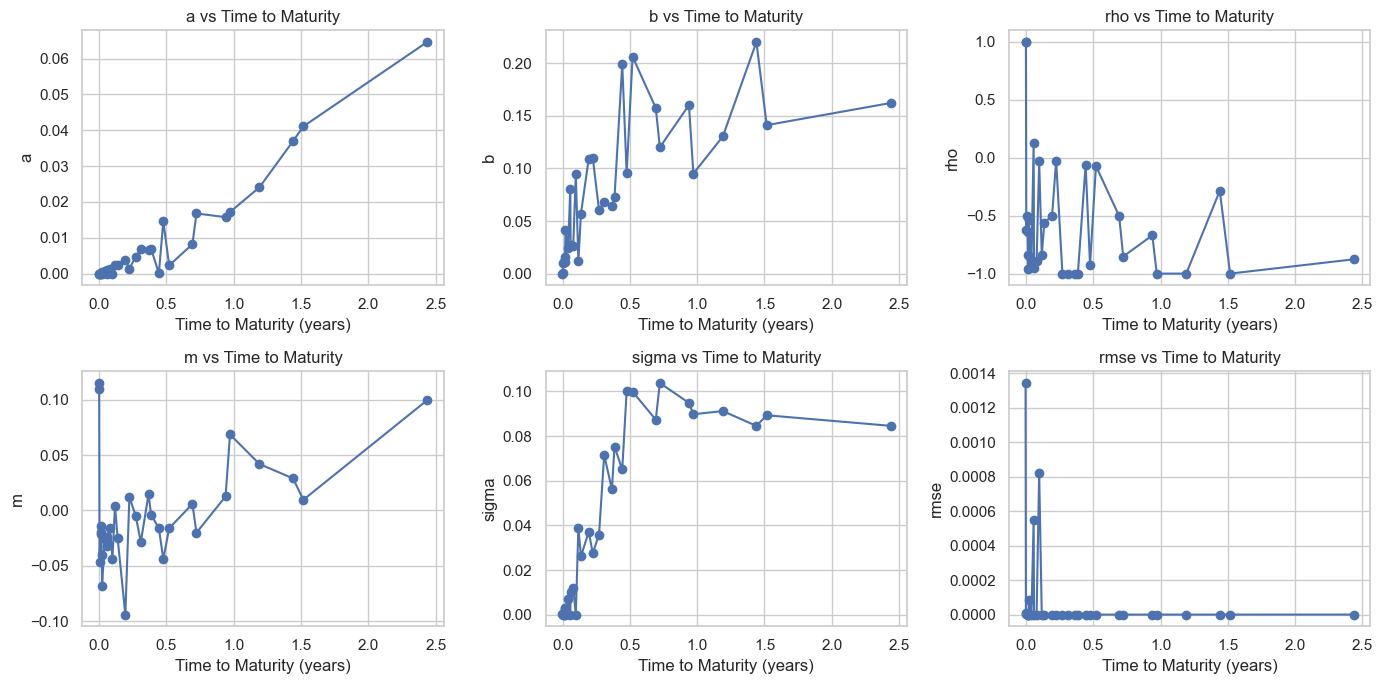

In [104]:
fig, axs = plt.subplots(2,3 , figsize=(14,7))
params = ['a', 'b', 'rho', 'm', 'sigma', 'rmse']

for i, param in enumerate(params):
    ax = axs[i//3][i%3]
    ax.plot(svi_df["ttm"], svi_df[param], marker="o")
    ax.set_title(f"{param} vs Time to Maturity")
    ax.set_xlabel("Time to Maturity (years)")
    ax.set_ylabel(param)
    ax.grid(True)

plt.tight_layout()    
plt.show()

Parameter a represents the overall variance level and due to the initalisation of 0 (variance cannot be negative, a≥0) noisy expiry is excluded.

Parameter b represents wing slop, that is, how fast variance increases in the wings. The model shows that this largely increases with time

Parameter rho represents skew direction and ranges from [-1.1]. From the rho vs ttm plot, it is higher for short-term maturities (rho>0 is atypical for equities)and a negative rho aligns with equity skew owning to high expense of OTM puts due to crash risks

Parameter m represents smile centre. It represents an horizontal shift of the smile and should be near 0

Parameter sigma represents curvature at the centre which controls smoothness 

RMSE displays how well the SVI model fits observed smile

#### **Building SVI 3-D Surface**

##### Creating interpolators - For smoother surface

In [109]:
from scipy.interpolate import interp1d

In [111]:
svi_df = svi_df.sort_values("ttm")

interp_funcs = {
    param: interp1d(
        svi_df["ttm"],
        svi_df[param],
        kind="linear",
        fill_value="extrapolate"
    )
for param in ["a","b","rho","m","sigma"]
}

##### Generate a grid of log-moneyness(K/F) and TTM Values

In [114]:
k_vals = np.linspace(-0.2,0.2,100)
ttm_vals = np.linspace(svi_df["ttm"].min(), svi_df["ttm"].max(), 80)

K, T = np.meshgrid(k_vals, ttm_vals)

##### Computing total variance and implied volatility over the grid

In [117]:
interp_funcs

{'a': <scipy.interpolate._interpolate.interp1d at 0x3178688c0>,
 'b': <scipy.interpolate._interpolate.interp1d at 0x317868780>,
 'rho': <scipy.interpolate._interpolate.interp1d at 0x316c63e30>,
 'm': <scipy.interpolate._interpolate.interp1d at 0x317a88690>,
 'sigma': <scipy.interpolate._interpolate.interp1d at 0x317a88dc0>}

In [118]:
def svi_total_variance_grid(k, t):
    a = interp_funcs["a"](t)
    b = interp_funcs["b"](t)
    rho = interp_funcs["rho"](t)
    m = interp_funcs["m"](t)
    sigma = interp_funcs["sigma"](t)

    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

w_grid = svi_total_variance_grid(K, T)  # Calculates variance using SVI model   

iv_grid = np.sqrt(np.maximum(w_grid/T,0)) # Converts variance to volatility v^2 = w(k)/T - Black sholes implied volatility

##### 3D Visualisation of Implied Volatility Surface

In [122]:
from mpl_toolkits.mplot3d import Axes3D

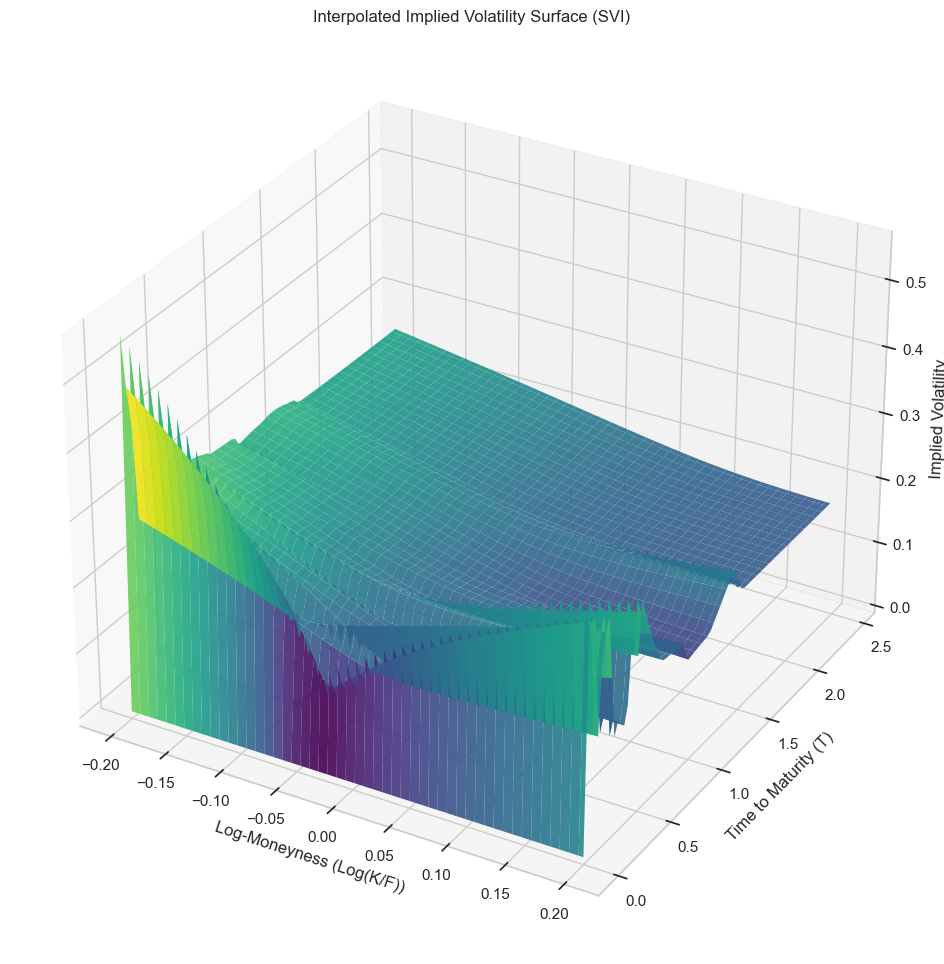

In [123]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(K, T, iv_grid, cmap="viridis", edgecolors="none", alpha=0.9)
ax.set_title("Interpolated Implied Volatility Surface (SVI)")
ax.set_xlabel("Log-Moneyness (Log(K/F))")
ax.set_ylabel("Time to Maturity (T)")
ax.set_zlabel("Implied Volatility")

plt.show()

In [124]:
k_vals

array([-0.2       , -0.1959596 , -0.19191919, -0.18787879, -0.18383838,
       -0.17979798, -0.17575758, -0.17171717, -0.16767677, -0.16363636,
       -0.15959596, -0.15555556, -0.15151515, -0.14747475, -0.14343434,
       -0.13939394, -0.13535354, -0.13131313, -0.12727273, -0.12323232,
       -0.11919192, -0.11515152, -0.11111111, -0.10707071, -0.1030303 ,
       -0.0989899 , -0.09494949, -0.09090909, -0.08686869, -0.08282828,
       -0.07878788, -0.07474747, -0.07070707, -0.06666667, -0.06262626,
       -0.05858586, -0.05454545, -0.05050505, -0.04646465, -0.04242424,
       -0.03838384, -0.03434343, -0.03030303, -0.02626263, -0.02222222,
       -0.01818182, -0.01414141, -0.01010101, -0.00606061, -0.0020202 ,
        0.0020202 ,  0.00606061,  0.01010101,  0.01414141,  0.01818182,
        0.02222222,  0.02626263,  0.03030303,  0.03434343,  0.03838384,
        0.04242424,  0.04646465,  0.05050505,  0.05454545,  0.05858586,
        0.06262626,  0.06666667,  0.07070707,  0.07474747,  0.07

In [125]:
T[1]

array([0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814813,
       0.02814813, 0.02814813, 0.02814813, 0.02814813, 0.02814

In [126]:
ttm_vals

array([-0.00273066,  0.02814813,  0.05902693,  0.08990572,  0.12078452,
        0.15166331,  0.18254211,  0.21342091,  0.2442997 ,  0.2751785 ,
        0.30605729,  0.33693609,  0.36781488,  0.39869368,  0.42957248,
        0.46045127,  0.49133007,  0.52220886,  0.55308766,  0.58396645,
        0.61484525,  0.64572404,  0.67660284,  0.70748164,  0.73836043,
        0.76923923,  0.80011802,  0.83099682,  0.86187561,  0.89275441,
        0.92363321,  0.954512  ,  0.9853908 ,  1.01626959,  1.04714839,
        1.07802718,  1.10890598,  1.13978478,  1.17066357,  1.20154237,
        1.23242116,  1.26329996,  1.29417875,  1.32505755,  1.35593634,
        1.38681514,  1.41769394,  1.44857273,  1.47945153,  1.51033032,
        1.54120912,  1.57208791,  1.60296671,  1.63384551,  1.6647243 ,
        1.6956031 ,  1.72648189,  1.75736069,  1.78823948,  1.81911828,
        1.84999708,  1.88087587,  1.91175467,  1.94263346,  1.97351226,
        2.00439105,  2.03526985,  2.06614864,  2.09702744,  2.12

In [128]:
len(T.ravel())

8000

##### ML Enhanced Surface Volatility Modeling

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [135]:
X = np.column_stack([K.ravel(), T.ravel()])
y = iv_grid.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=16
)

In [136]:
rf = RandomForestRegressor(n_estimators=100, random_state=16)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=16)

In [138]:
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE on test set: {rmse:.6f}")

Random Forest RMSE on test set: 0.002234


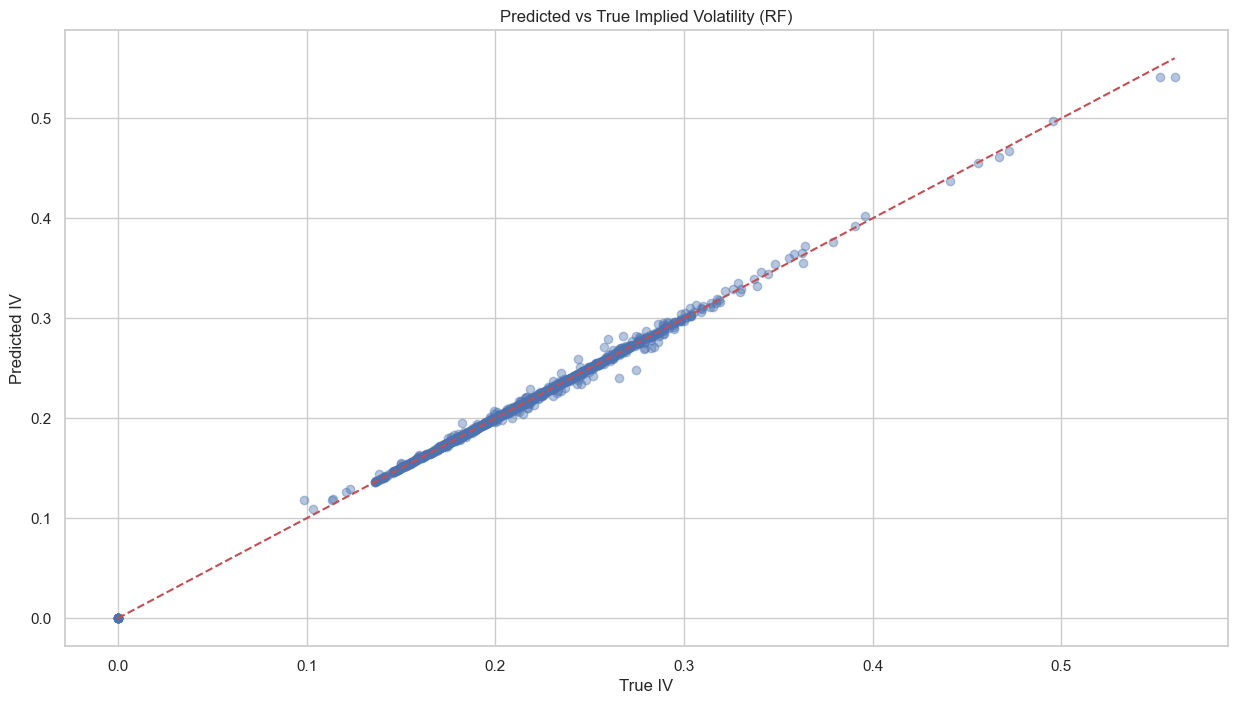

In [139]:
# Predictions vs Groundtruth
plt.figure(figsize=(15,8))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--")
plt.xlabel("True IV")
plt.ylabel("Predicted IV")
plt.title("Predicted vs True Implied Volatility (RF)")
plt.grid(True)
plt.show()

In [140]:
[min(y_test), max(y_test)], [min(y_test), max(y_test)]

([0.0, 0.5600030449744728], [0.0, 0.5600030449744728])

##### Using ML Model for Surface Prediction

In [142]:
K_new, T_new = np.meshgrid(k_vals, ttm_vals)
X_new =np.column_stack([K_new.ravel(), T_new.ravel()])

In [143]:
iv_ml_pred = rf.predict(X_new).reshape(K_new.shape)

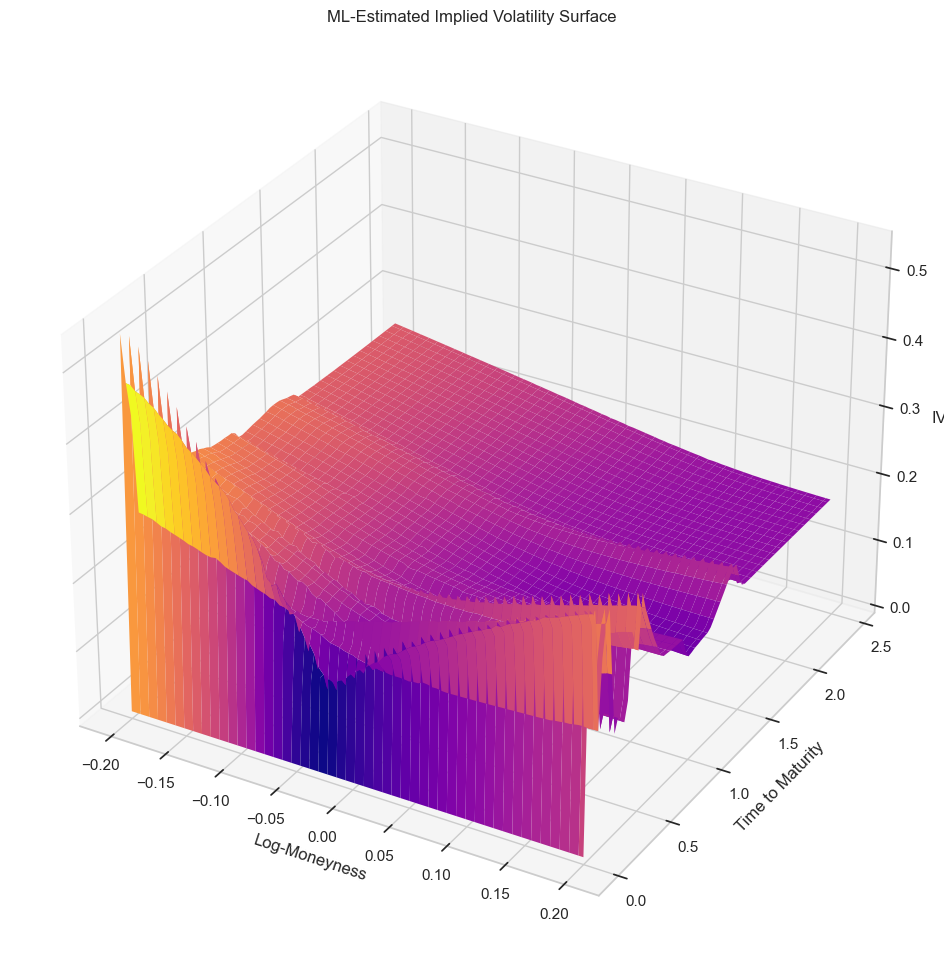

In [144]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(K_new, T_new, iv_ml_pred, cmap="plasma", edgecolor="none")
ax.set_title("ML-Estimated Implied Volatility Surface")
ax.set_xlabel("Log-Moneyness")
ax.set_ylabel("Time to Maturity")
ax.set_zlabel("IV")
plt.show()

This ML model, while it is not learning from raw market data but from synthetic surface generated by SVI it is use test if it can mimic the SVI surface. The benefit of this is that it can be used to replace SVI for pricing millions of options at a faster rate and in the case where the model being used is a neural net, a differentiable function can be used to compute gradients (∂IV/∂K, ∂IV/∂T)

#### Constructing Neural Network Model Directly on Market Data

In [256]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [160]:
smile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   strike             7080 non-null   float64       
 1   lastPrice          7080 non-null   float64       
 2   bid                7080 non-null   float64       
 3   ask                7080 non-null   float64       
 4   bid-ask-spread     7080 non-null   float64       
 5   mid_price          7080 non-null   float64       
 6   impliedVolatility  7080 non-null   float64       
 7   inTheMoney         7080 non-null   bool          
 8   expiry             7080 non-null   datetime64[ns]
 9   option_type        7080 non-null   object        
 10  ttm                7080 non-null   float64       
 11  moneyness          7080 non-null   float64       
 12  log_moneyness      7080 non-null   float64       
 13  volume             6876 non-null   float64       
dtypes: bool(

In [162]:
X = smile_df[["ttm","log_moneyness"]]
y = smile_df["impliedVolatility"]

In [164]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=16)

In [237]:
model = Sequential([
    Input(shape=(2,)),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
early_stop = EarlyStopping(patience=10,restore_best_weights=True)

In [239]:
# Training model
history = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0634 - val_loss: 0.0328
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.0336 - val_loss: 0.0296
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.0327 - val_loss: 0.0293
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.0359 - val_loss: 0.0282
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 0.0301 - val_loss: 0.0276
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 0.0307 - val_loss: 0.0272
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0297 - val_loss: 0.0260
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0312 - val_loss: 0.0260
Epoch 9/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 0.0240 - val_loss: 0.0260
Epoch 10/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 0.0288 - val_loss: 0.0273
Epoch 11/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 0.0269 - val_loss: 0.0243
Epoch 12/100
142/14

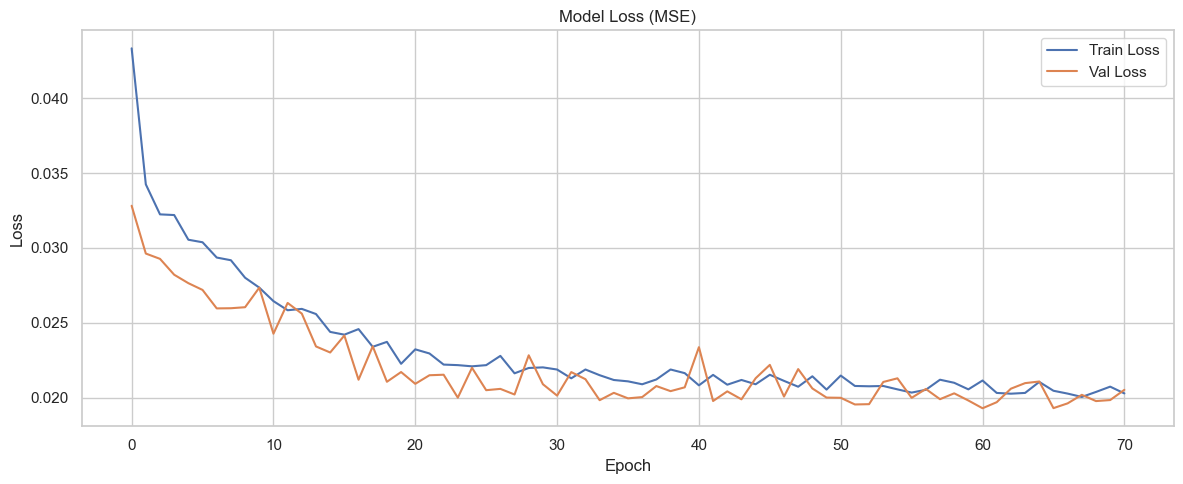

In [240]:
plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# y_pred = model.predict(X_test).flatten()

In [244]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Neural Network Test RMSE: {rmse:.6f}")

Neural Network Test RMSE: 0.187658


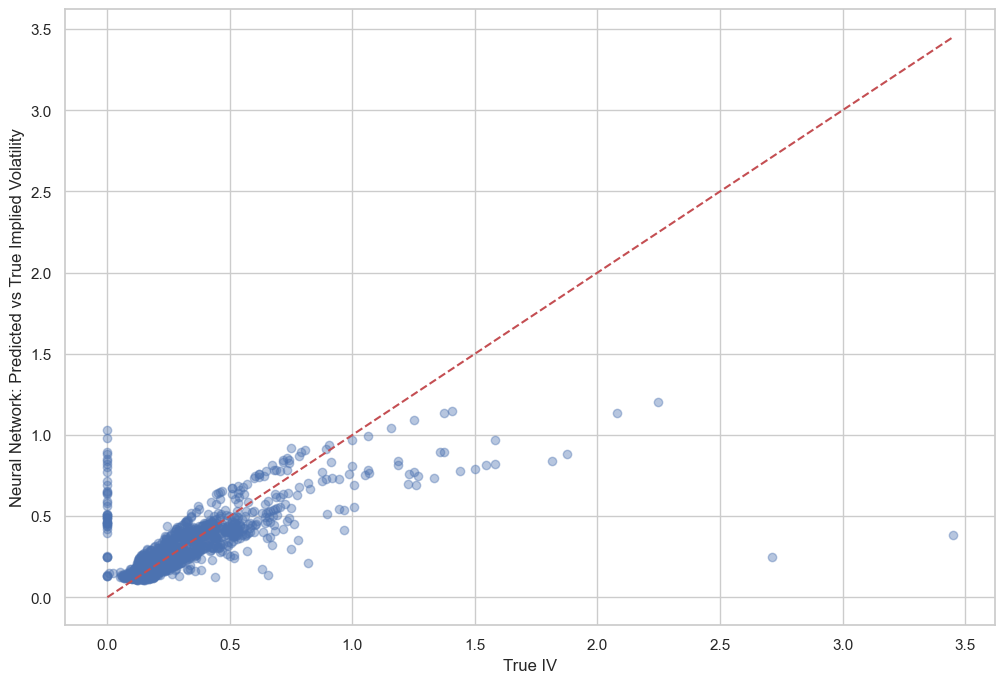

In [246]:
plt.figure(figsize=(12,8))

plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--")
plt.xlabel("True IV")
plt.ylabel("Neural Network: Predicted vs True Implied Volatility")
plt.grid(True)
plt.show()

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


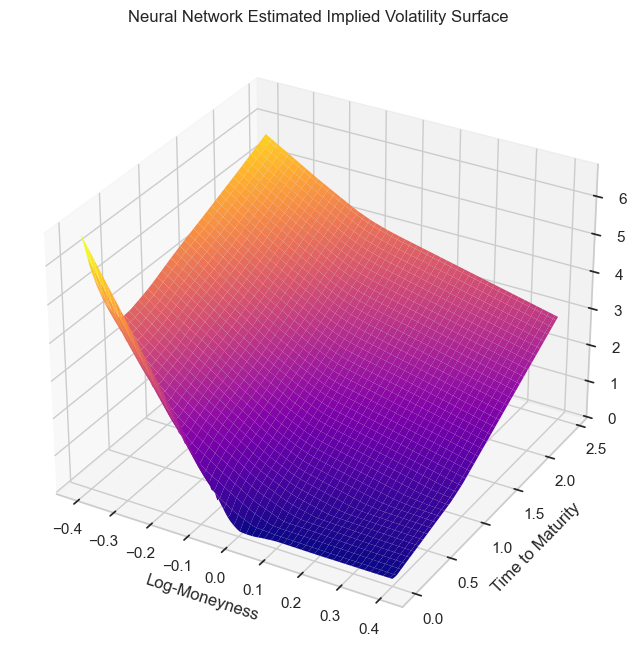

In [248]:
nn_K_grid, nn_T_grid = np.meshgrid(
    np.linspace(-0.4,0.4,100),
    np.linspace(smile_df["ttm"].min(), smile_df["ttm"].max(), 80)
)

X_surface = np.column_stack([nn_K_grid.ravel(), nn_T_grid.ravel()])
X_surface_scaled = scaler.transform(X_surface)

iv_nn_pred = model.predict(X_surface_scaled).reshape(nn_K_grid.shape)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(nn_K_grid, nn_T_grid, iv_nn_pred, cmap="plasma", edgecolor="none")
ax.set_title("Neural Network Estimated Implied Volatility Surface")
ax.set_xlabel("Log-Moneyness")
ax.set_ylabel("Time to Maturity")
ax.set_zlabel("IV")
plt.show()

In [258]:
iv_nn_pred = model.predict(X_surface_scaled)

# Convert X_surface_scaled to tf.Variable so it's differentiable
X_tensor = tf.Variable(X_surface_scaled, dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(X_tensor)  # track gradients w.r.t. inputs
    iv_tensor = model(X_tensor)

# Compute ∇IV = [∂IV/∂log_k, ∂IV/∂T]
grads = tape.gradient(iv_tensor, X_tensor)

grad_k = grads[:, 0].numpy().reshape(nn_K_grid.shape)
grad_t = grads[:, 1].numpy().reshape(nn_T_grid.shape)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step


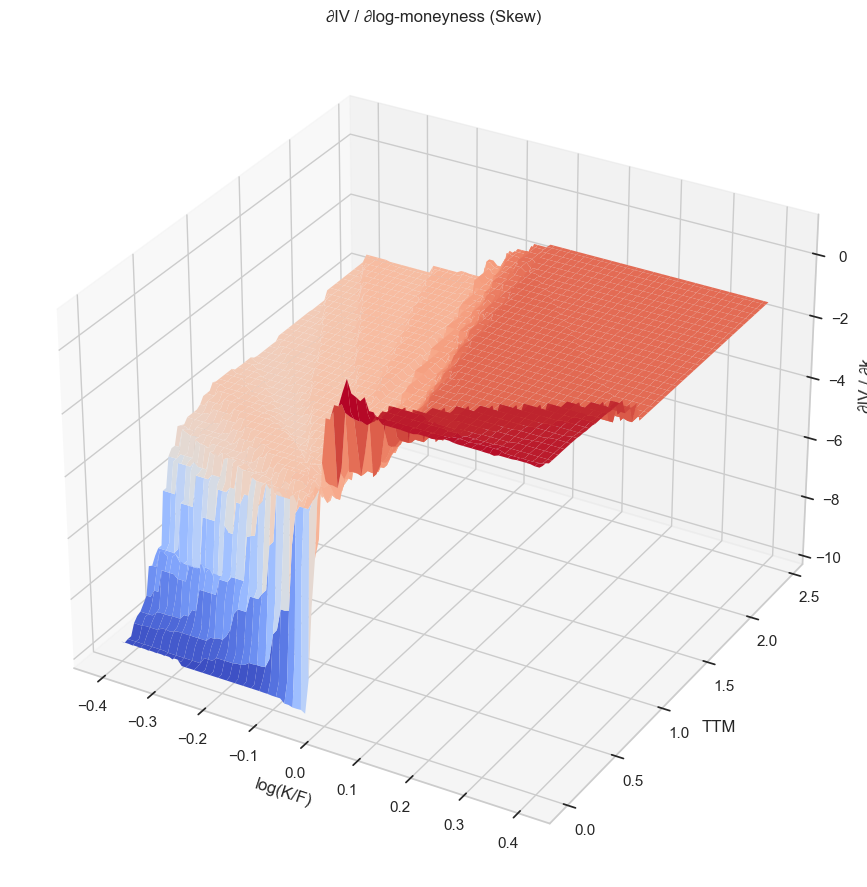

In [266]:
fig = plt.figure(figsize=(20, 11))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(nn_K_grid, nn_T_grid, grad_k, cmap='coolwarm', edgecolor='none')
ax.set_title("∂IV / ∂log-moneyness (Skew)")
ax.set_xlabel("log(K/F)")
ax.set_ylabel("TTM")
ax.set_zlabel("∂IV / ∂k")
plt.show()

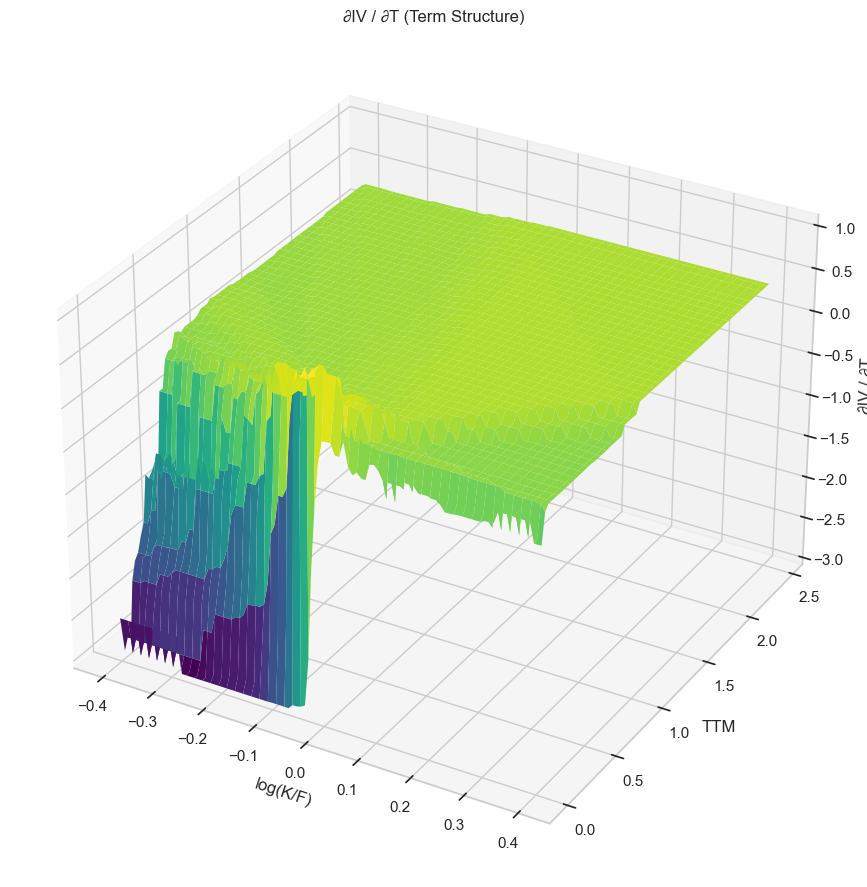

In [264]:
fig = plt.figure(figsize=(20, 11))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(nn_K_grid, nn_T_grid, grad_t, cmap='viridis', edgecolor='none')
ax.set_title("∂IV / ∂T (Term Structure)")
ax.set_xlabel("log(K/F)")
ax.set_ylabel("TTM")
ax.set_zlabel("∂IV / ∂T")
plt.show()